In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import OrderedDict
import matplotlib.pyplot as plt

from scipy import interp

import warnings
import seaborn as sns
sns.despine()

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import binarize

from sklearn.pipeline import Pipeline
try:
    from sklearn.externals import joblib
except ImportError:
    import joblib

from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit

from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

import sys
sys.path.append('../scripts')
from helper_functions import *

<Figure size 432x288 with 0 Axes>

### Load Funsite-PPI training and validation datasets

In [2]:
training_data_ML = pd.read_csv('../datasets/PPI/PPI_training_dataset.csv')
validation_data_ML = pd.read_csv('../datasets/PPI/PPI_validation_dataset.csv')

#### Define Features to use in the PPI model

In [3]:
features_ff = ['scons','avg_scons','sc5_gs','sc5_scons', 'conserved_hotspot_struc_neighbourhood', 'conserved_surface_hotspot_struc_neighbourhood', 'highly_conserved_struc_neighbourhood', 'highly_conserved_surface_struc_neighbourhood', 'pocket_conserved_struc_neighbourhood', 'pocket_surface_conserved_struc_neighbourhood',
               'avg_charged', 'avg_cx', 'avg_dpx', 'avg_electric_effect', 'avg_flexibility', 'avg_hydropathicity', 'avg_hydrophobicity', 'avg_polarity', 'avg_surface_residues', 'avg_surrounding_hydrophobicity', 'dist_to_hotspot', 'dist_to_surface', 'hotspot_struc_neighbourhood', 'pocket_struc_neighbourhood', 'surface_residues_struc_neighbourhood', 'min_dist_to_cleft123', 'min_dist_to_cleft_1', 'min_dist_to_cleft_2', 'min_dist_to_cleft_3', 'surface_residue_rsa', 'cleft_residue', 'hydrophobic_aa', 'polar_aa',
               'alpha','betweenness','bulkiness','charge','cleft_depth','cleft_num','closeness','degree','foldx_alascan','free_energy_solution','hydration_potential','hydropathicity','hydropathy_index','hydrophobicity','hydrophobicity_psaia','kappa','localised_electrical_effect','max_cx','max_dpx','min_cx','min_dpx','nhBonds_ptr','oBonds_ptr','phi','polarity','psi','resTco','res_bfactor_n','rsa_allatoms','rsa_mainchain','rsa_nonpolar','rsa_polar','rsa_totside','van_der_waals_vol_normalised',
               'dssp_type_B','dssp_type_H','dssp_type_NO_PRED','dssp_type_T',
               'A_pssm_ff','A_wop_ff','C_pssm_ff','C_wop_ff','D_pssm_ff','D_wop_ff','E_pssm_ff','E_wop_ff','F_pssm_ff','F_wop_ff','G_pssm_ff','G_wop_ff','H_pssm_ff','H_wop_ff','I_pssm_ff','I_wop_ff','K_pssm_ff','K_wop_ff','L_pssm_ff','L_wop_ff','M_pssm_ff','M_wop_ff','N_pssm_ff','N_wop_ff','P_pssm_ff','P_wop_ff','Q_pssm_ff','Q_wop_ff','R_pssm_ff','R_wop_ff','S_pssm_ff','S_wop_ff','T_pssm_ff','T_wop_ff','V_pssm_ff','V_wop_ff','W_pssm_ff','W_wop_ff','Y_pssm_ff','Y_wop_ff','gapless_match_to_pseudocounts_ff','info_per_pos_ff',
              ]

features_generic = [
               'bulkiness','charge','cleft_depth','cleft_num','hydration_potential','hydropathicity','hydropathy_index','hydrophobicity','localised_electrical_effect','max_cx','max_dpx','min_cx','min_dpx','mutability','polarity','psi','resTco','res_bfactor_n','rsa_allatoms','van_der_waals_vol_normalised','dssp_type_B','dssp_type_H','dssp_type_NO_PRED','dssp_type_T',
               'residue_aa_A','residue_aa_C','residue_aa_D','residue_aa_E','residue_aa_F','residue_aa_G','residue_aa_H','residue_aa_I','residue_aa_K','residue_aa_L','residue_aa_M','residue_aa_N','residue_aa_P','residue_aa_Q','residue_aa_R','residue_aa_S','residue_aa_T','residue_aa_V','residue_aa_W','residue_aa_Y',
               'A_pssm_psiblast','A_wop_psiblast','C_pssm_psiblast','C_wop_psiblast','D_pssm_psiblast','D_wop_psiblast','E_pssm_psiblast','E_wop_psiblast','F_pssm_psiblast','F_wop_psiblast','G_pssm_psiblast','G_wop_psiblast','H_pssm_psiblast','H_wop_psiblast','I_pssm_psiblast','I_wop_psiblast','S_pssm_psiblast','K_pssm_psiblast','K_wop_psiblast','L_pssm_psiblast','L_wop_psiblast','M_pssm_psiblast','M_wop_psiblast','R_wop_psiblast','N_pssm_psiblast','N_wop_psiblast','P_pssm_psiblast','P_wop_psiblast','Q_pssm_psiblast','Q_wop_psiblast','R_pssm_psiblast','S_wop_psiblast','T_pssm_psiblast','T_wop_psiblast','V_pssm_psiblast','V_wop_psiblast','Y_wop_psiblast','Y_pssm_psiblast','W_wop_psiblast','W_pssm_psiblast','info_per_pos_psiblast','gapless_match_to_pseudocounts_psiblast','entwop_score_psiblast',        
              ]

In [35]:

len(training_data_ML.domain.value_counts())

1850

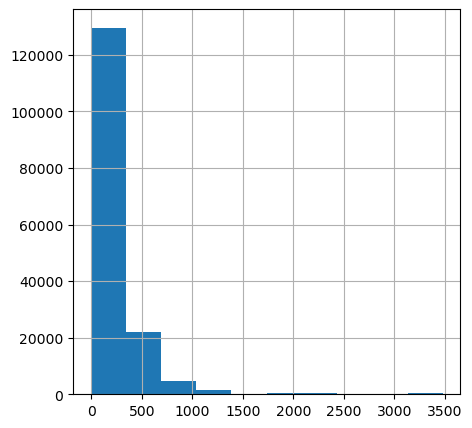

In [38]:
training_data_ML.domain_residue.hist()

In [42]:
df = training_data_ML.copy()
df['pdb'] = training_data_ML.domain.apply(lambda x: x[:4])

In [43]:
df[df.pdb=='1jeq']

,residue_string,A_pssm_ff,A_pssm_psiblast,A_wop_ff,A_wop_psiblast,C_pssm_ff,C_pssm_psiblast,C_wop_ff,C_wop_psiblast,D_pssm_ff,...,residue_aa_S,residue_aa_T,residue_aa_V,residue_aa_W,residue_aa_Y,dssp_type_B,dssp_type_H,dssp_type_NO_PRED,dssp_type_T,pdb


In [44]:
df[['pdb', 'domain']]

,pdb,domain
0,3cf0,3cf0G01
1,4lw4,4lw4B01
2,4h9o,4h9oA00
3,2x5d,2x5dD02
4,3ajx,3ajxB00
...,...,...
159817,1wok,1wokA02
159818,3abe,3abeC00
159819,2po2,2po2B00
159820,2qfv,2qfvB00


In [47]:
df[df.pdb=='3cf0'].to_csv('JW_3cf0_residues.csv')

In [48]:
import os
os.getcwd()

'/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/funsite_models'

In [41]:
training_data_ML.domain.apply(lambda x: x[:4]).value_counts()

3kyc    552
1pys    390
1sxj    370
3a9t    365
1rbl    356
       ... 
2qy0      1
3tjo      1
2o4c      1
1s9d      1
3d2e      1
Name: domain, Length: 1684, dtype: int64

In [34]:
for d, c in training_data_ML.domain.value_counts().iteritems():
    print(d,c)

1bxbB00 336
1rblG02 292
3l75P00 277
3b07A00 277
1q1lA00 271
1xkqD00 267
3mhsA02 257
2rjsB02 256
2nuuC00 252
2qfvB00 249
2d4vB00 249
3vr6C02 248
3blxG00 248
3oq8D00 248
3zs0D00 247
2zydB02 241
4h1tB00 241
1p80B01 240
4acfE02 239
2yevD01 237
3kzwF02 237
4oc9M01 235
2gsaA02 235
4i7uD00 234
1k9sF00 234
2reqA01 231
2f2aA00 230
2tbvC00 230
4dpgA02 229
4ls5B01 228
4hsoC00 227
4tv8B01 227
2v5hF00 227
4qroA00 227
2po2B00 225
3ek6D00 223
2bp7C00 222
3tmqA00 220
3kycA00 219
2trcB00 219
3cdkC01 219
2gbwE01 218
2ynmB00 218
4fc4E00 218
3v8hA00 218
1rv3B02 218
3dwfA00 218
3ausB00 217
1telB02 216
2bumB00 216
3t94C00 216
1wyuD03 215
3hvqB00 215
2r6gA01 215
3madB03 213
2bwnB02 212
2briA00 211
3wgbC01 211
1tkkB02 211
1pysA00 210
3seqB01 210
3lvjB02 209
2f9iB00 209
1pvyA00 208
1i7wC00 207
3iwpA00 205
2ux8C00 205
4e1oA02 204
1y2oA00 203
4fgjA00 203
3lgeA00 202
1xtgA00 202
2x5dD02 202
1u7vB00 202
3a3yA02 202
2a0uA02 201
1xm3B00 201
3tjrA00 200
1wyeA00 200
4phcA01 200
4r8kA01 199
4oc6B00 198
4ki8G03 198
1rpx

4hf0B00 39
4c2mE02 39
4hx3D00 39
3slzA00 39
2v4mA02 39
3camB00 39
2qtvB00 38
4jdrA03 38
2qjoA02 38
3cqzA04 38
1hfeS00 38
4lnuB02 38
3cjhD00 38
3dh1D00 38
2o28B01 38
1pjqA04 38
1sr4A00 38
2cciB02 38
3mkiA00 38
3bq7B00 38
5azuC00 38
3sfdC02 37
1ssmB02 37
4i98C01 37
1sp4A01 37
4mzwA02 37
2c2vT00 37
2eimC01 37
2w83A00 37
2aenD01 37
3bpdC01 37
3qb5K01 37
4oc9D02 36
3e04D01 36
4u5wC00 36
3phtB00 36
3ab2D02 36
1r8sE02 36
1pn9B02 36
4p4kB01 36
3ziaN03 36
1qlbE01 36
2fu3B04 36
2v41A02 36
3s5lB02 36
3dxrB00 36
1uvqB01 36
1wv4B00 36
1xruB02 36
3hnjC00 36
3cb2A02 35
4o4lC02 35
1ungD00 35
3jwnH02 35
1re5D03 35
1t98B01 35
2xqnT02 35
1r4mI00 35
3wcyI00 35
3hs2A00 35
4qnhB00 35
3hy2X01 34
3e0mB01 34
4qjfB01 34
2nvuC01 34
2hjmC01 34
3c6fC01 34
2wqlA00 34
3ixqB02 34
3fpqB01 34
2d0pA03 34
2p9sG00 34
3oeeE01 34
4a64A01 34
1racB01 33
2y6tB01 33
4ju5B02 33
2b4sB01 33
3rq3B00 33
1wdjB00 33
4i1iB01 33
2bngB00 33
4or5B01 33
3ayzB02 33
2riaC00 33
2xceB01 33
2j3tD01 33
4nawA00 32
2pihB00 32
3s8iA00 32
3dqgA00 32

In [36]:
set(validation_data_ML.domain.unique()).intersection(set(training_data_ML.domain.unique()))

set()

In [26]:
# 113 columns (selected for training)
# 201 columns in the original training dataset
# 159,822 rows
# 0 Null values
# 1850 domains (including some with less than 5 residues)
# No

# JW code 
for col in training_data_ML.columns:
    print(col)

residue_string
A_pssm_ff
A_pssm_psiblast
A_wop_ff
A_wop_psiblast
C_pssm_ff
C_pssm_psiblast
C_wop_ff
C_wop_psiblast
D_pssm_ff
D_pssm_psiblast
D_wop_ff
D_wop_psiblast
E_pssm_ff
E_pssm_psiblast
E_wop_ff
E_wop_psiblast
F_pssm_ff
F_pssm_psiblast
F_wop_ff
F_wop_psiblast
G_pssm_ff
G_pssm_psiblast
G_wop_ff
G_wop_psiblast
H_pssm_ff
H_pssm_psiblast
H_wop_ff
H_wop_psiblast
I_pssm_ff
I_pssm_psiblast
I_wop_ff
I_wop_psiblast
K_pssm_ff
K_pssm_psiblast
K_wop_ff
K_wop_psiblast
L_pssm_ff
L_pssm_psiblast
L_wop_ff
L_wop_psiblast
M_pssm_ff
M_pssm_psiblast
M_wop_ff
M_wop_psiblast
N_pssm_ff
N_pssm_psiblast
N_wop_ff
N_wop_psiblast
P_pssm_ff
P_pssm_psiblast
P_wop_ff
P_wop_psiblast
Q_pssm_ff
Q_pssm_psiblast
Q_wop_ff
Q_wop_psiblast
R_pssm_ff
R_pssm_psiblast
R_wop_ff
R_wop_psiblast
SF
S_pssm_ff
S_pssm_psiblast
S_wop_ff
S_wop_psiblast
T_pssm_ff
T_pssm_psiblast
T_wop_ff
T_wop_psiblast
V_pssm_ff
V_pssm_psiblast
V_wop_ff
V_wop_psiblast
W_pssm_ff
W_pssm_psiblast
W_wop_ff
W_wop_psiblast
Y_pssm_ff
Y_pssm_psiblast
Y_wop_

In [32]:
training_data_ML.head()

,residue_string,A_pssm_ff,A_pssm_psiblast,A_wop_ff,A_wop_psiblast,C_pssm_ff,C_pssm_psiblast,C_wop_ff,C_wop_psiblast,D_pssm_ff,...,residue_aa_R,residue_aa_S,residue_aa_T,residue_aa_V,residue_aa_W,residue_aa_Y,dssp_type_B,dssp_type_H,dssp_type_NO_PRED,dssp_type_T
0,3cf0G01_558,3.0,-2.0,37.0,1.0,-3.0,-3.0,0.0,0.0,-1.0,...,0,0,0,0,0,0,0,1,0,0
1,4lw4B01_351,6.0,6.0,83.0,96.0,3.0,0.0,7.0,1.0,-4.0,...,0,0,0,0,0,0,1,0,0,0
2,4h9oA00_49,-2.0,-2.0,0.0,0.0,1.0,-1.0,4.0,2.0,-3.0,...,1,0,0,0,0,0,0,1,0,0
3,2x5dD02_81,0.0,-2.0,7.0,0.0,-5.0,-4.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
4,3ajxB00_2032,-2.0,-3.0,0.0,0.0,-5.0,-6.0,0.0,0.0,-4.0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
# JW code
training_data_ML[[c for c in training_data_ML.columns if 'annotation' in c]].mean()

/var/folders/mf/x9gl62g95fxd519t8mbpkhfw0000gn/T/ipykernel_46032/2829384076.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  training_data_ML[[c for c in training_data_ML.columns if 'annotation' in c]].mean()


annotation_3DID_INTERCHAIN        0.241663
annotation_3DID_INTRACHAIN        0.045726
annotation_BIOLIP                 0.014910
annotation_IBIS_LIG               0.042916
annotation_IBIS_PPI_INTERCHAIN    0.385760
annotation_IBIS_PPI_INTRACHAIN    0.037223
annotation_MCSA                   0.000094
annotation_PROTINDB               0.343532
dtype: float64

In [31]:
# JW code
len(y) - sum(y)

98169

In [4]:
X_ff = training_data_ML[features_ff]
X_generic = training_data_ML[features_generic]

y = training_data_ML['annotation_IBIS_PPI_INTERCHAIN']

In [5]:
def get_pr_curve_model_pred_dataset(X, y, groups):
    
    y_real=[]
    y_proba=[]
    
    i = 0
    
    for train, test in group_kfold.split(X, y, groups):
        
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]

        classifier = XGBClassifier(

            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,

        )
        
        classifier.fit(X_train, y_train)
        
        pred_proba = classifier.predict_proba(X_test)
        precision, recall, thresholds = precision_recall_curve(y_test, pred_proba[:, 1])
        y_real.append(y_test)
        y_proba.append(pred_proba[:,1])

        i += 1
        
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    precision_overall, recall_overall, _ = precision_recall_curve(y_real, y_proba)
    pr_auc_overall = auc(recall, precision)
        
    return (precision_overall, recall_overall, pr_auc_overall)

In [6]:
domgroups = training_data_ML['domain'].tolist()
groups = domgroups

group_kfold = GroupKFold(n_splits=5)

precision_ff, recall_ff, pr_auc_ff = get_pr_curve_model_pred_dataset(X_ff, y, groups)
precision_generic, recall_generic, pr_auc_generic = get_pr_curve_model_pred_dataset(X_generic, y, groups)

label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_generic)

/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:38:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:57:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:15:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:15:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:32:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:56:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:10:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:18:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:18:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:28:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:28:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:37:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:37:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:49:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


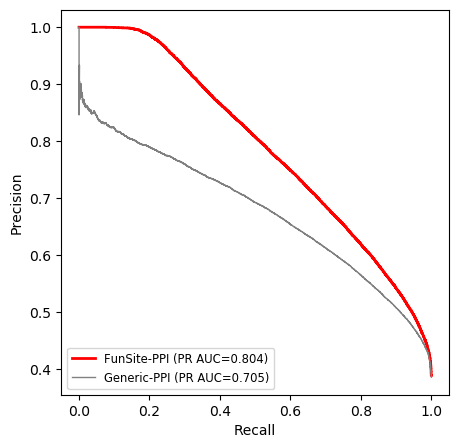

In [7]:
label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_generic)

plt.rcdefaults()
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['axes.facecolor']='white'

plt.plot(recall_ff, precision_ff, label=label_ff, lw=2, color='red')
plt.plot(recall_generic, precision_generic, label=label_generic, lw=1, color='grey')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', fontsize='small')
#plt.savefig('PPI-ibis_interchain_vs_generic.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
xmodel_ff = XGBClassifier(
            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
    
)

xmodel_gen = XGBClassifier(

            n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
)

xmodel_ff.fit(X_ff, y)
xmodel_gen.fit(X_generic, y)

# Saving models with joblib
modelname = 'PPI_Funsite_model_JW_version.sav'
joblib.dump(xmodel_ff, modelname)

/Users/judewells/Documents/dataScienceProgramming/cath-funsite-predictor/FunsiteEnv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:26:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "njobs", "reg_apha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  b

['PPI_Funsite_model_JW_version.sav']

### FunSite-PPI compared to other predictors on the PPI holdout set

In [10]:
X_val_funsite = validation_data_ML[features_ff]
X_val_generic = validation_data_ML[features_generic]

y_val = validation_data_ML['annotation_IBIS_PPI_INTERCHAIN']

validation_funsite_pred = xmodel_ff.predict_proba(X_val_funsite)[:, 1]
validation_generic_pred = xmodel_gen.predict_proba(X_val_generic)[:, 1]

precision_val_ff, recall_val_ff, thresholds_val_ff = precision_recall_curve(y_val,validation_funsite_pred)
precision_val_generic, recall_val_generic, thresholds_val_generic = precision_recall_curve(y_val,validation_generic_pred)
pr_auc_val_ff = auc(recall_val_ff, precision_val_ff)
pr_auc_val_generic = auc(recall_val_generic, precision_val_generic)

label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_val_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_val_generic)

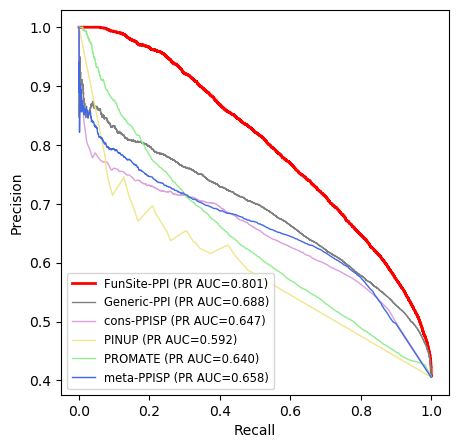

In [11]:
validation_cons_ppisp = validation_data_ML['cons_ppisp']
validation_pinup = validation_data_ML['pinup']
validation_promate = validation_data_ML['promate']
validation_meta_ppisp = validation_data_ML['meta_ppisp']
validation_meta_ppisp_predict = validation_data_ML['meta_predict']

precision_val_cons_ppisp, recall_val_cons_ppisp, thresholds_val_cons_ppisp = precision_recall_curve(y_val,validation_cons_ppisp)
precision_val_pinup, recall_val_pinup, thresholds_val_pinup = precision_recall_curve(y_val,validation_pinup)
precision_val_promate, recall_val_promate, thresholds_val_promate = precision_recall_curve(y_val,validation_promate)
precision_val_meta_ppisp, recall_val_meta_ppisp, thresholds_val_meta_ppisp = precision_recall_curve(y_val,validation_meta_ppisp)
precision_val_meta_ppisp_predict, recall_val_meta_ppisp_predict, thresholds_val_meta_ppisp_predict = precision_recall_curve(y_val,validation_meta_ppisp_predict)

pr_auc_val_cons_ppisp = auc(recall_val_cons_ppisp, precision_val_cons_ppisp)
pr_auc_val_pinup = auc(recall_val_pinup, precision_val_pinup)
pr_auc_val_promate = auc(recall_val_promate, precision_val_promate)
pr_auc_val_meta_ppisp = auc(recall_val_meta_ppisp, precision_val_meta_ppisp)
pr_auc_val_meta_ppisp_predict = auc(recall_val_meta_ppisp_predict, precision_val_meta_ppisp_predict)

label_cons_ppisp = 'cons-PPISP (PR AUC=%.3f)' % (pr_auc_val_cons_ppisp)
label_pinup = 'PINUP (PR AUC=%.3f)' % (pr_auc_val_pinup)
label_promate = 'PROMATE (PR AUC=%.3f)' % (pr_auc_val_promate)
label_meta_ppisp = 'meta-PPISP (PR AUC=%.3f)' % (pr_auc_val_meta_ppisp)
label_meta_ppisp_predict = 'meta-PPISP-predict (PR AUC=%.3f)' % (pr_auc_val_meta_ppisp_predict)

label_ff = 'FunSite-PPI (PR AUC=%.3f)' % (pr_auc_val_ff)
label_generic = 'Generic-PPI (PR AUC=%.3f)' % (pr_auc_val_generic)

plt.plot(recall_val_ff, precision_val_ff, label=label_ff, lw=2, color='red')
plt.plot(recall_val_generic, precision_val_generic, label=label_generic, lw=1, color='grey')

plt.plot(recall_val_cons_ppisp, precision_val_cons_ppisp, label=label_cons_ppisp, lw=1, color='plum')#
plt.plot(recall_val_pinup, precision_val_pinup,label=label_pinup,  lw=1, color='khaki')#
plt.plot(recall_val_promate, precision_val_promate, label=label_promate,  lw=1, color='lightgreen')#
plt.plot(recall_val_meta_ppisp, precision_val_meta_ppisp, label=label_meta_ppisp, lw=1, color='royalblue')
#plt.plot(recall_val_meta_ppisp_predict, precision_val_meta_ppisp_predict, label=label_meta_ppisp_predict, lw=1, color='blue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(fontsize='small', loc='lower left')
#plt.savefig('PPI-IBIS_INTERCHAIN_vs_others_TEST.png', dpi=300, bbox_inches='tight')
plt.show()

(array([2717., 2041., 2236., 2750., 3319., 3970., 4410., 4986., 5734.,
        7977.]),
 array([0.00316325, 0.10276281, 0.20236237, 0.30196193, 0.4015615 ,
        0.50116104, 0.60076064, 0.7003602 , 0.7999597 , 0.8995593 ,
        0.99915886], dtype=float32),
 <a list of 10 Patch objects>)

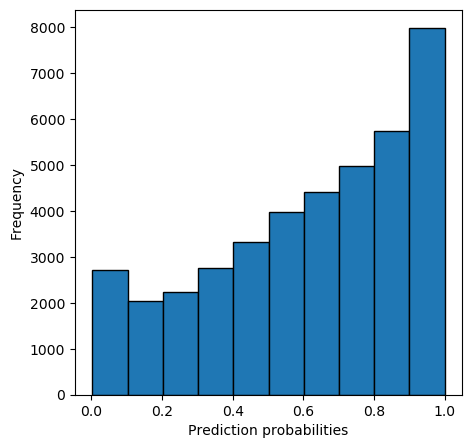

In [24]:
plt.xlabel('Prediction probabilities')
plt.ylabel('Frequency')

plt.hist(validation_funsite_pred, edgecolor='black', linewidth=1) 
#plt.savefig('PPI_validation_prediction_probabilities_hist.png', dpi=300, bbox_inches='tight')

In [12]:
import sklearn
from sklearn import metrics
sorted(sklearn.metrics.SCORERS.keys())
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score, make_scorer

mcc_scorer = make_scorer(matthews_corrcoef)

xg_scores_ff = cross_validate(xmodel_ff, X_ff, y, groups, scoring=mcc_scorer, cv=GroupKFold(n_splits=5))
xg_scores_gen = cross_validate(xmodel_gen, X_generic, y, groups, scoring=mcc_scorer, cv=GroupKFold(n_splits=5))

diff_scores = ['roc_auc','accuracy', 'precision', 'recall', 'f1']

xg_scores_ff = cross_validate(xmodel_ff, X_ff, y, groups, scoring=diff_scores, cv=GroupKFold(n_splits=5))
xg_scores_gen = cross_validate(xmodel_gen, X_generic, y, groups, scoring=diff_scores, cv=GroupKFold(n_splits=5))

print('ROC_AUC:')
print('ff=',xg_scores_ff['test_roc_auc'].mean(), 'generic=', xg_scores_gen['test_roc_auc'].mean())

print('\nPrecision:')
print('ff=',xg_scores_ff['test_precision'].mean(),  'generic=', xg_scores_gen['test_precision'].mean())

print('\nRecall')
print('ff=',xg_scores_ff['test_recall'].mean(),  'generic=', xg_scores_gen['test_recall'].mean())

print('\nF1:')
print('ff=',xg_scores_ff['test_f1'].mean(),  'generic=', xg_scores_gen['test_f1'].mean())

print('\nAccuracy:')
print('ff=',xg_scores_ff['test_accuracy'].mean(), 'generic=', xg_scores_gen['test_accuracy'].mean())

ROC_AUC:
ff= 0.8381758040593537 generic= 0.7854045061772477

Precision:
ff= 0.5412554912521111 generic= 0.493588648360271

Recall
ff= 0.901892163270183 generic= 0.921234781000725

F1:
ff= 0.6764760845707278 generic= 0.6427787561280796

Accuracy:
ff= 0.6671922417099027 generic= 0.605004324726885


#### Generate FunSite-PPI model without 175 domains for combined predictor

domains175_list = ['3mddA03', '1itqA00', '1xa8A00', '1os7A00', '1oroA00', '1ct9A02', '1odtC00', '1qprA02', '1d4aA00', '1fdyA00', '1cjuA00', '1n0hB03', '1j21A01', '2hwgA03', '1zp3A00', '1fuqA02', '1arzA02', '1soxA02', '1b8gA02', '1v54A00', '1ordA02', '1qinA00', '1rm0A01', '3csmA00', '2qutA00', '2c3mA01', '1kwsA00', '1ct9A01', '1kqfC00', '1idtA00', '1dqsA02', '1rk2A00', '1mumA00', '1mt5A00', '1l8sA00', '1d8dB00', '1nvmA02', '1wgiA00', '1rypI00', '2ahjA00', '1psdA02', '1j49A02', '1dqsA01', '1grcA00', '1ivhA02', '1qsgA00', '1cb7B01', '1cjuB00', '1jm6A01', '1a50B02', '1cb7A00', '1afrA00', '1nbaA00', '2ag0B01', '1oasA01', '1j79A00', '1e19A00', '1dqaA03', '1oe8A01', '2gsaA02', '2ocpA00', '1hyoA02', '1d8hA00', '2qf7A04', '1h7xA05', '1gpmA02', '1ksjA00', '1gz6A01', '1f61A00', '2esdA02', '1pvdB01', '1x7dA02', '1b7yA00', '1rvvA00', '3ey9A03', '1hxqA02', '1cqjA02', '1apxA02', '1dtwA00', '1bmfD02', '1tkkA02', '1hy3A00', '1fuiA02', '1ndoE01', '1ycfA01', '1dtwB02', '1ey3A01', '4mdhA02', '1xldA00', '1qhfA00', '2qf7A02', '1u8vA03', '1l6gB02', '1fc4A01', '1uqtA02', '1dqaA02', '1trkB02', '1djoA01', '1n62B05', '1cl1A01', '1j21A02', '1reqA01', '2gh5B03', '1dekA02', '1nwwA00', '1bouB00', '1hrkA02', '12asA00', '1snnA00', '1bzyA00', '1iphA01', '1cf2P02', '1cevA00', '1trkA01', '1dqrA02', '1ybvA00', '1dxeA00', '1ozhA04', '1mroA02', '1fr8A00', '1mpyA02', '1oacA03', '1a05A00', '1dqrA01', '1gxsA00', '2cjaA02', '2pz0A00', '1bxrA02', '1rgqA02', '1dhfA00', '1n0hA01', '1n2cA02', '1dtyA02', '1rblA02', '1iydA02', '1pvdA03', '3ecaB02', '1b57A00', '1niaA01', '1gt7A00', '1l6gA01', '1nfsA00', '1n2cB01', '1imaA01', '1fuiA03', '1f2dA01', '1diiA04', '1oasA02', '1gzgA00', '1htoA01', '1hzzA01', '1b3rA01', '1jrpB04', '1do6A00', '2hdhA01', '1diiC00', '1p4rA04', '1alkA00', '1qfeA00', '1ec9A02', '1uaqA00', '1dbtA00', '1hr6B01', '1g64A00', '1g99A02', '1bd3A00', '1a50A00', '2ahjB01', '1aq0A00', '1sesA02', '1rozA00', '1i58A00', '1ndpB00', '1d8dA00', '1x9hA01']

ppidf_no175 = raw_feature_data[~raw_feature_data['domain'].isin(domains175_list)]
ppi = ppidf_no175[(ppidf_no175.annotation_IBIS_PPI_INTERCHAIN== 1) ]
ppi_doms = ppi.domain.unique()

nonppi = ppidf_no175[(ppidf_no175.annotation_IBIS_PPI_INTERCHAIN == 0 ) & ppidf_no175.domain.isin(ppi_doms)] 
nonppi['index']=nonppi['residue_string']
ppi['index']=ppi['residue_string']

ppidf_no175_trainML = preprocess_site_nonsite_df(ppi, nonppi, 4)
ppidf_no175_trainML.sort_values(['domain']).head(2)

X_no175 = ppidf_no175_trainML[features_ff]
y_no175 = ppidf_no175_trainML['annotation_IBIS_PPI_INTERCHAIN']

ppi_model_no175 = XGBClassifier(

    n_estimators = 1000,
            learning_rate = 0.01,
            subsample = 0.8,
            colsample_bytree = 0.8,
            max_depth=7, 
            gamma=1,
            reg_apha=1,
            objective = 'binary:logistic',
            scale_pos_weight = 4,
            njobs=-1,
)
ppi_model_no175.fit(X_no175, y_no175)

modelname = 'PPI_Funsite_xmodel_no175.sav'
joblib.dump(ppi_model_no175, modelname)